In [1]:
#|default_exp accel

# Denoising Diffusion Probabilistic Models (DDPM) with miniai

## Imports

In [2]:
#|export
import pickle,gzip,math,os,time,shutil,torch,random,logging
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from functools import partial

from fastcore.foundation import L
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *

In [3]:
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

mpl.rcParams['image.cmap'] = 'gray_r'
logging.disable(logging.WARNING)

In [4]:
# SET SEED to compare
seed_value = 42
torch.manual_seed(seed_value)

## Load dataset

In [5]:
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

@inplace
def transformi(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2)) for o in b[xl]]

bs = 128
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=8)

In [6]:
dt = dls.train
xb, yb = next(iter(dt))

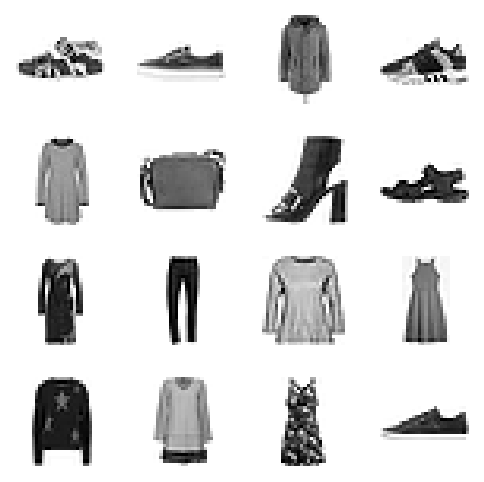

In [7]:
show_images(xb[:16], imsize=1.5)

## Parameters of the DDPM

In [8]:
# from "4. Experiments" in https://arxiv.org/pdf/2006.11239.pdf
beta_min, beta_max, n_steps = 0.0001, 0.02, 1000

# FORWARD PROCESS
"""We set the forward process variances to constants 
# increasing linearly from β1 = 10−4 to βT = 0.02."""
beta = torch.linspace(beta_min, beta_max, n_steps)

"""A notable property of the forward process is that it admits sampling xt at an
arbitrary timestep t in closed form: using the notation αt := 1 − βt and ¯αt := ∏t
s=1 αs"""
alpha = 1. - beta
alpha_bar = alpha.cumprod(0)

"""Experimentally, both σ2t = βt and σ2t = ˜βt = 1− ¯αt−1 1− ¯αt βt had similar results"""
sigma = beta.sqrt()

### Visualise our parameters

In [ ]:
plt.plot(beta)

In [ ]:
plt.plot(alpha)

In [ ]:
plt.plot(alpha_bar)

In [ ]:
plt.plot(sigma)

### Noisify
We are writing the function for noisify, which first randomly generates a time step t, then adds noise to the image using the normal distribution and corresponding mean and variance at that time step.

In [ ]:
#def noisify(x0, alpha_bar):
num_samples = xb[:16].shape[0]
t = torch.randint(0, n_steps, (num_samples,))


In [ ]:
type(alpha_bar)

In [ ]:
alpha_bar[t]

In [ ]:
t

Let's take index 82 to verify that our code is working correctly.

In [ ]:
alpha_bar[82]

In [ ]:
alpha_bar_t_sqrt = alpha_bar[t].sqrt().reshape(-1,1,1,1)
alpha_bar_t_complement = (1. - alpha_bar[t]).reshape(-1,1,1,1)

In [ ]:
xb.shape

In [ ]:
mean_dist_t = alpha_bar_t_sqrt * xb[:16]
var_dist_t = alpha_bar_t_complement * torch.eye(xb[:16].size(1) * xb[:16].size(2) * xb[:16].size(3), device=xb[:16].device)
mean_dist_t, var_dist_t

In [ ]:
alpha_bar_t_sqrt.reshape(-1, 1, 1, 1).shape

In [ ]:
xb[:16].shape

Let's put everything into a function.

In [9]:
def noisify(x0, alpha_bar):
    device = x0.device
    num_img = x0.shape[0]
    t = torch.randint(0, n_steps, (num_img,))
    noise = torch.randn(x0.shape).to(device)
    alpha_bar_t = alpha_bar[t].reshape(-1,1,1,1).to(device)
    xt = alpha_bar_t.sqrt() * x0 + (1. - alpha_bar_t).sqrt() * noise
    return (xt, t.to(device)), noise

In [ ]:
(xt, t), noise = noisify(xb[:25], alpha_bar)

In [ ]:
t

In [ ]:
titles = fc.map_ex(t, '{}')
show_images(xt, imsize=1.5, titles=titles)

Great! Our noisify function is working accordingly.

## Training

In [10]:
from diffusers import UNet2DModel

### Sampling
Sampling generates diverse and realistic samples from a distribution. These samples can then be used as training data for the model to learn the inverse dynamics/representation of the underlying noise distribution.

For this notebook, we are following Algorithm 2 Sampling from the DDPM paper.

In [ ]:
model = UNet2DModel(in_channels=1, out_channels=1, block_out_channels=(16, 32, 64, 64), norm_num_groups=8)

In [ ]:
# DUMMY first
device = next(model.parameters()).device

In [ ]:
size = tuple(xb.shape)

#### Step 1 of Algorithm 2: Create xt

In [ ]:
xt = torch.randn(size, device=device)

#### Step 2 of Algorithm 2 is a loop
We will ignore the loop for now to focus on the individual steps and make sure they are correct. Our loop is meant to iterate from `n_steps` to `1`. We will trivially take our time `t` to be `n_steps` (1000).

In [ ]:
t = 999

In [ ]:
# need t_batch for model prediction
t_batch = torch.full((size[0],), t, device=device, dtype=torch.long)
t_batch

#### Step 3: Random noise

In [ ]:
z = (torch.randn_like(xt, device=device)) if t > 1 else torch.zeros(xt.shape, device=device)
z

In [ ]:
alpha[t]

### Step 4 part a: apply diffusion model to current sample

In [ ]:
(hidden_state_out, ) = model(xt, t_batch, return_dict=False)
type(hidden_state_out)

In [ ]:
# removing predicted noise from image
xt_hat = xt - (1 - alpha[t])/(1 - alpha_bar[t]).sqrt() * hidden_state_out

In [ ]:
# scale the predicted 'cleaner' image and add back some noise
x_t_minus_1 = (1 / alpha[t].sqrt()) * xt_hat + sigma[t] * z
x_t_minus_1

In [ ]:
x_t_minus_1.shape

We append `x_t_minus_1` to our `preds` list. Why? So that we can keep track of the change to our image from pure noise to hopefully something that works.

### Jeremy Howard's code
I'm going to 'cheat' a little by using Jeremy Howard's code at this point in time, especially to set up model etc. I'll still be using my own `sample` code to check for its correctness.

In [84]:
@torch.no_grad()
def sample(model, sz, alpha, alpha_bar, sigma, n_steps):
    device = next(model.parameters()).device
    x_t = torch.randn(sz, device=device)
    preds = []
    for t in reversed(range(n_steps)):
        t_batch = torch.full((x_t.shape[0],), t, device=device, dtype=torch.long)
        # `t`'s last value is 0
        z = (torch.randn(x_t.shape, device=device)) if t > 0 else torch.zeros(x_t.shape, device=device)
        # Equation 15- Approximate x_0 from x_0_hat
        x_0_hat = (x_t - (1 - alpha_bar[t]).sqrt() * learn.model((x_t, t_batch)).to(device)) / alpha_bar[t].sqrt()
        x_0_hat = x_0_hat.clamp(-1,1)

        # Equation 7- Update predicted image using x_0_hat and x_t
        x_t = (alpha_bar[t-1].sqrt() * (1 - alpha[t])) / (1. - alpha_bar[t]) * x_0_hat + \
              (alpha[t].sqrt() * (1 - alpha_bar[t-1])) / (1. - alpha_bar[t]) * x_t + \
              sigma[t] * z  

        preds.append(x_t.cpu())

    return preds

In [58]:
# Jeremy Howard's code
class DDPMCB(Callback):
    order = DeviceCB.order+1
    def __init__(self, n_steps, beta_min, beta_max):
        super().__init__()
        fc.store_attr()
        self.beta = torch.linspace(self.beta_min, self.beta_max, self.n_steps)
        self.α = 1. - self.beta 
        self.ᾱ = torch.cumprod(self.α, dim=0)
        self.σ = self.beta.sqrt()
    
    def before_batch(self, learn): learn.batch = noisify(learn.batch[0], self.ᾱ)
    def sample(self, model, sz): return sample(model, sz, self.α, self.ᾱ, self.σ, self.n_steps)

In [59]:
class UNet(UNet2DModel):
    def forward(self, x): return super().forward(*x).sample

In [60]:
ddpm_cb = DDPMCB(n_steps=1000, beta_min=0.0001, beta_max=0.02)

In [61]:
model = UNet(in_channels=1, out_channels=1, block_out_channels=(16, 32, 64, 64), norm_num_groups=8)

Next, we run a single batch to see if our model is working correctly, i.e. is it actually denoising images.

[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

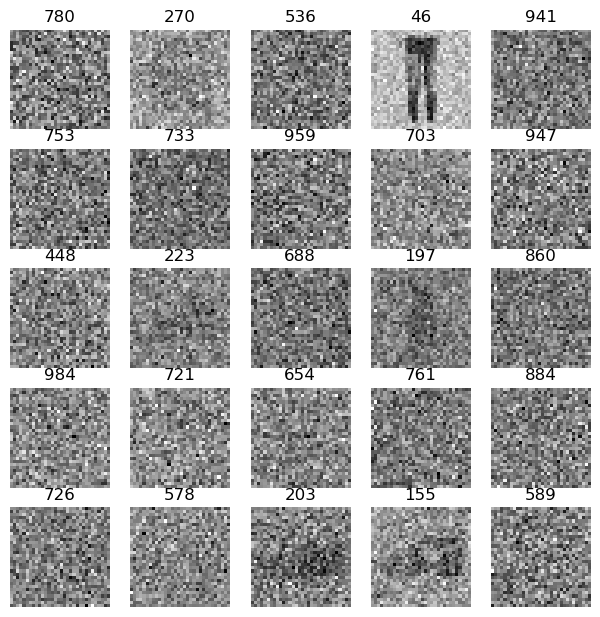

In [62]:
learn = TrainLearner(model, dls, nn.MSELoss())
learn.fit(train=False, cbs=[ddpm_cb,SingleBatchCB()])
(xt,t), epsilon = learn.batch
show_images(xt[:25], titles=fc.map_ex(t[:25], '{}'), imsize=1.5)

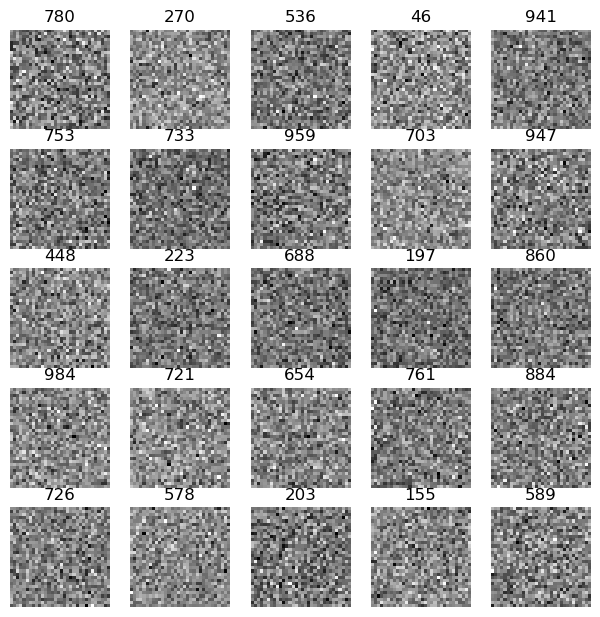

In [63]:
show_images(epsilon[:25], titles=fc.map_ex(t[:25], '{}'), imsize=1.5)

I believe `epsilon` refers to noise, but it is not visually distinct.

Let's now train our model on our produced sample. We are using a U-Net, which has its architecture already defined on HuggingFace. We will train it to predict the noise at relevant time steps.

The following is Jeremy Howard's code as well.

In [75]:
lr = 5e-3
epochs = 5

tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [ddpm_cb, DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched)]

In [76]:
model = UNet(in_channels=1, out_channels=1, block_out_channels=(16, 32, 64, 128), norm_num_groups=8)

In [77]:
def init_ddpm(model):
    for o in model.down_blocks:
        for p in o.resnets:
            p.conv2.weight.data.zero_()
            for p in fc.L(o.downsamplers): init.orthogonal_(p.conv.weight)

    for o in model.up_blocks:
        for p in o.resnets: p.conv2.weight.data.zero_()

    model.conv_out.weight.data.zero_()

In [78]:
init_ddpm(model)

In [79]:
opt_func = partial(optim.Adam, eps=1e-5)

In [80]:
learn = TrainLearner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

loss,epoch,train
0.000,0,train
0.000,0,eval
0.000,1,train
0.000,1,eval
0.000,2,train
0.000,2,eval
0.000,3,train
0.000,3,eval
0.000,4,train
0.000,4,eval


[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

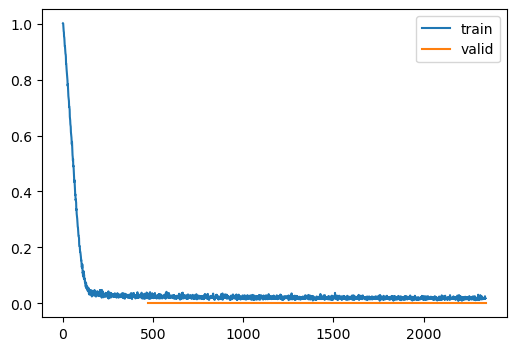

[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

In [81]:
learn.fit(epochs)

## Sampling

In [85]:
samples = ddpm_cb.sample(learn.model, (16, 1, 32, 32))

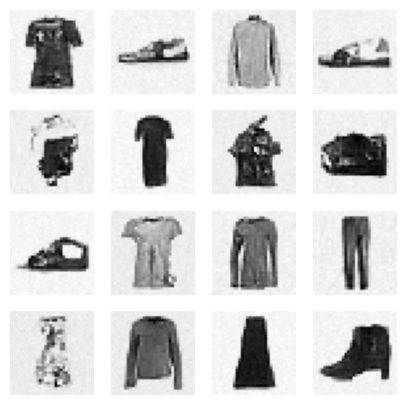

In [86]:
show_images(samples[-1], figsize=(5,5))